# **Superconductivity Regression Notebook - Testing Single Models**
Trains models to predict critical temperatures based on features found with "*../code/get_featurizers.ipynb*". Imports data from "*../data/supercon_feat.csv*", which is produced in *get_featurizers.ipynb*. The orginal data is from the supercon database. This notebook is for testing single models.

*Author: Kirk Kleinsasser*

In [1]:
import dill
#dill.load_session('../data/latest-run.db') #this can load a saved python session so I don't need to rerun computationally expensive cells
%autosave 300 
#autosaves code every five minutes

Autosaving every 300 seconds


## Import Libraries / Define Import Data Function

In [2]:
#general imports:
import warnings #to suppress grid search warnings
import numpy as np 
import pandas as pd
import lolopy.learners #allows easy uncertainty
import matplotlib.pyplot as plt
import seaborn as sns #heatmaps
import forestci as fci #error for RFR - http://contrib.scikit-learn.org/forest-confidence-interval/index.html

#regression models:
from mlens.ensemble import SuperLearner
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR
from xgboost import XGBRegressor

#various ML tools:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from skopt import BayesSearchCV #bayesian optimization

#imports the data from get_featurizers. Function because some models we may want infinity:
def import_data(replace_inf=False):
    global data, target, train_data, test_data, train_target, test_target #variables that we want to define globally (outside of this funtion)
    data = pd.DataFrame(pd.read_csv('./supercon_features.csv')) #loads data produced in get_featurizer.ipynb
    target = data.pop('Tc') #remove target (critical temp) from data

    if replace_inf: #replaces values of infinity with NaN if replace_inf is True
        data.replace([np.inf, -np.inf], np.nan, inplace=True) 

    #TODO: debug feaurizers - NaN is entered when there is an error in the featurizer
    data.drop(['name','Unnamed: 0', 'composition'], axis=1, inplace=True) #drop columns irrelevant to training
    data = data[data.columns[data.notnull().any()]] #drop columns that are entirely NaN (12 columns) 

    for col in data: #replaces NaN with zeros
        data[col] = pd.to_numeric(data[col], errors ='coerce').fillna(0).astype('float')

    #creates a test train split, with shuffle and random state for reproducibility 
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.15, random_state=43, shuffle=True)

Failed to import duecredit due to No module named 'duecredit'
[MLENS] backend: threading


## Evaluation Functions
To train models and return results

In [3]:
warnings.filterwarnings("ignore")
def evaluate_one(model_name, regressor, parameters, error=False): #define function that trains a model and prints scores and plots
    global train_data, train_data, test_data, test_target #we need these variables and don't want to pass them as arguments
    with plt.rc_context({'xtick.color':'white', 'ytick.color':'white','axes.titlecolor':'white','figure.facecolor':'#1e1e1e','text.color':'white','legend.labelcolor':'black'}):
        plt.title(f"{model_name} - Prediction vs. Actual Value (CV)", color='white')
        model = regressor(**parameters) #unpacks model and params
        if model_name in ("Superlearner", "Random Forest Regression - Lolopy"):
            model.fit(train_data.values, train_target.values) #fit the model
        else:
            model.fit(train_data, train_target) #fit the model
        model_pred = model.predict(test_data) #make predictions on test data

        mse = round(mean_squared_error(test_target, model_pred),3) #find mean square error
        mae = round(mean_absolute_error(test_target, model_pred),3) #find mean square error
        mxe = round(max_error(test_target, model_pred),3)
        r_squared = round(r2_score(test_target, model_pred),3) #find r2 score

        #make our plot - with plt.rc_context sets theme to look good in dark mode
        difference = np.abs(test_target - model_pred) #function that finds the absolute difference between predicted and actual value
        im = plt.scatter(model_pred, test_target, cmap='plasma_r', norm=plt.Normalize(0, 120), c=difference, label="Critical Temperature (K)", zorder=2) #create scatter plot of data 
        plt.plot((0,135), (0,135), 'k--', alpha=0.75, zorder=3) #add expected line. Values must be changed with different data to look good
        if error: #plot error bars
            model_unbiased = fci.random_forest_error(model, train_data, test_data)
            plt.errorbar(model_pred, test_target, yerr=np.sqrt(model_unbiased), fmt=".", ecolor="black", alpha=0.5, zorder=1)
        plt.title(model_name, c='white')
        plt.ylabel('Actual Value', c='white')
        plt.xlabel('Prediction', c='white')
        plt.annotate(f'R2: {r_squared}', xy = (0, -0.15), xycoords='axes fraction', ha='left', va="center", fontsize=10) #add footnote with R2 
        plt.annotate(f'MXE: {mxe}', xy = (0, -0.20), xycoords='axes fraction', ha='left', va="center", fontsize=10) #add footnote with R2 
        plt.annotate(f'MAE: {mae}', xy = (1.0, -0.20), xycoords='axes fraction', ha='right', va="center", fontsize=10) #add footnote with MAE
        plt.annotate(f'MSE: {mse}', xy = (1.0, -0.15), xycoords='axes fraction', ha='right', va="center", fontsize=10) #add footnote with MSE
        plt.legend()
        plt.colorbar().set_label(label="Difference from Actual (K)", color='white') #using .set_label() as colorbar() does accept color arguments
        plt.show()

## Linear Regression

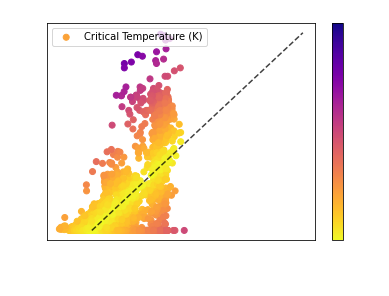

In [4]:
import_data(replace_inf=True) #reimport data without infinities

evaluate_one("Linear Regression", LinearRegression, {})

## Support Vector Regression

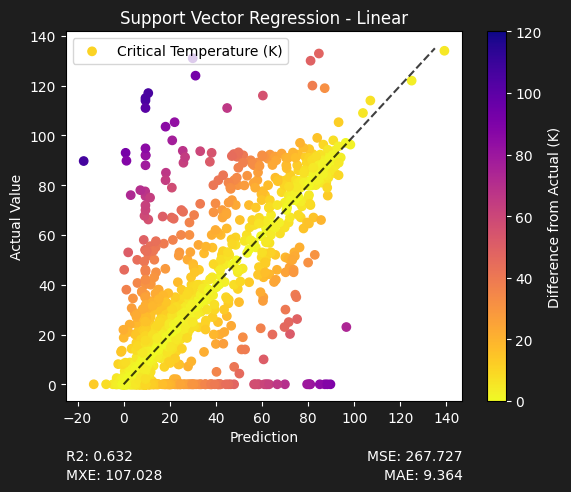

In [5]:
evaluate_one("Support Vector Regression - Linear", SVR, {'kernel':'rbf', 'C':100, 'epsilon':0.1, 'gamma':0.1, 'degree':1})

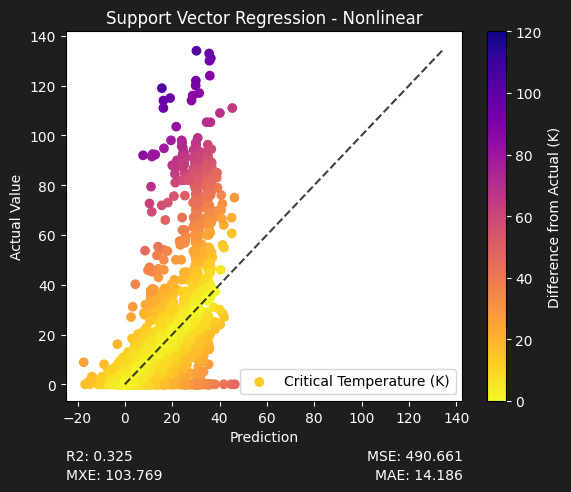

In [6]:
evaluate_one("Support Vector Regression - Nonlinear", SVR, {'C':1, 'epsilon':10, 'gamma':'auto', 'kernel':'linear'})

## Elastic Net Regressor

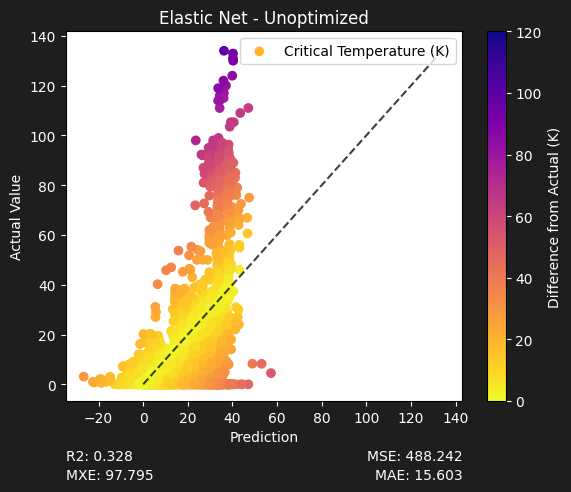

In [7]:
evaluate_one("Elastic Net - Unoptimized", ElasticNet, {})

/home/sylphrena/anaconda3/envs/CLASSE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.111e+06, tolerance: 1.016e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


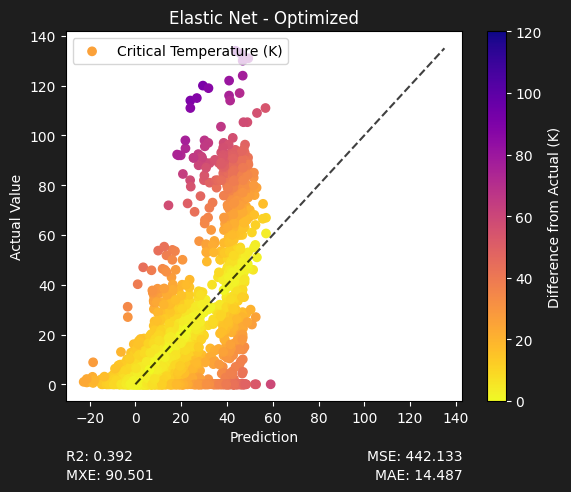

In [8]:
evaluate_one("Elastic Net - Optimized", ElasticNet, {'alpha':1e-05, 'l1_ratio':0.0})

## Descision Tree Regressor

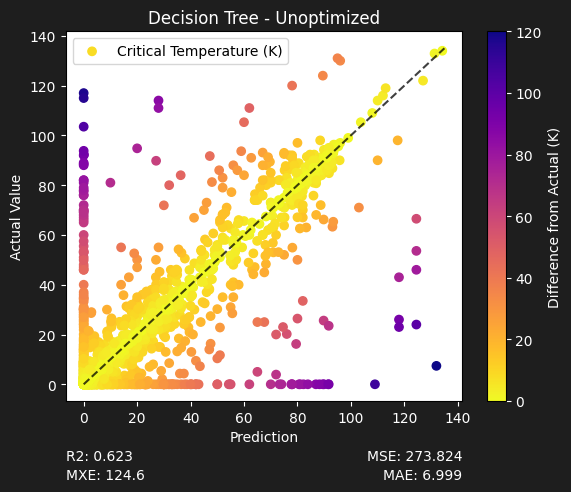

In [9]:
evaluate_one("Decision Tree - Unoptimized", DecisionTreeRegressor, {})

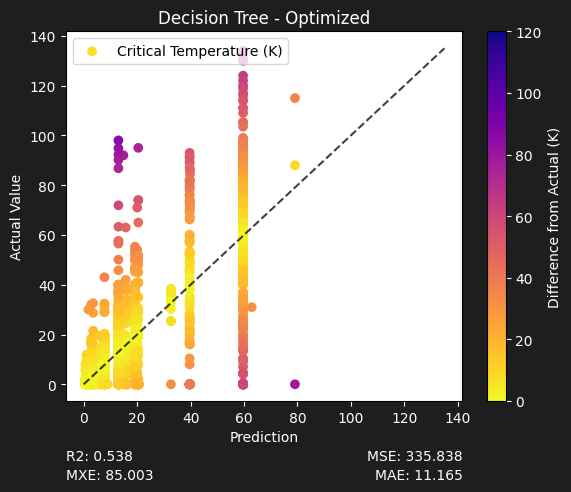

In [10]:
evaluate_one("Decision Tree - Optimized", DecisionTreeRegressor, {'criterion':'poisson', 'max_depth':5, 'max_features':0.5})

## Random Forest Regressor

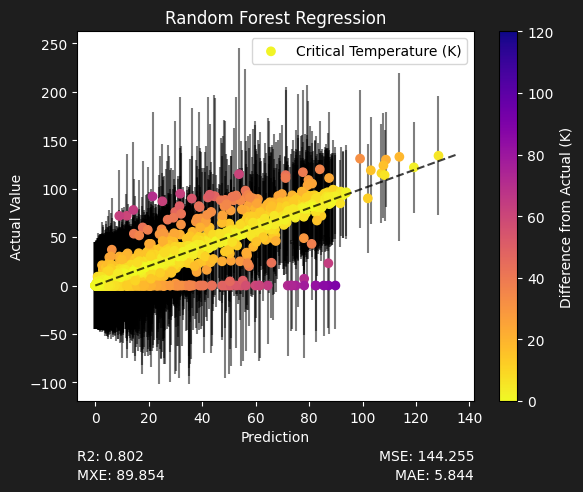

In [11]:
import_data(replace_inf=True)
evaluate_one("Random Forest Regression", RandomForestRegressor, {}, error=True)
#compare with lolopy

In [ ]:
import_data(replace_inf=True)
evaluate_one("Random Forest Regression - Lolopy", lolopy.learners.RandomForestRegressor, {}, error=False)
#compare with lolopy

## KNeighbors Regressor

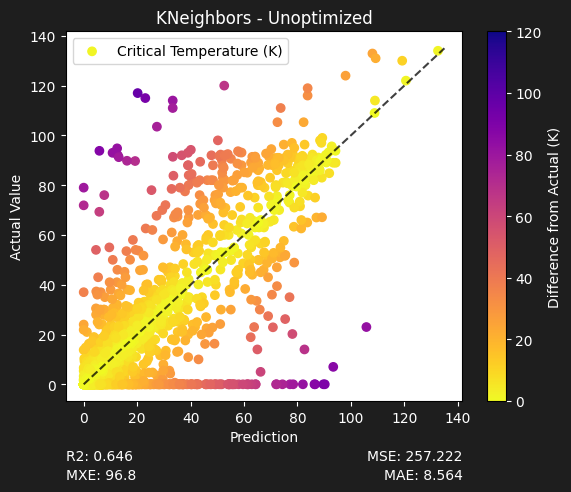

In [13]:
evaluate_one("KNeighbors - Unoptimized", KNeighborsRegressor, {})

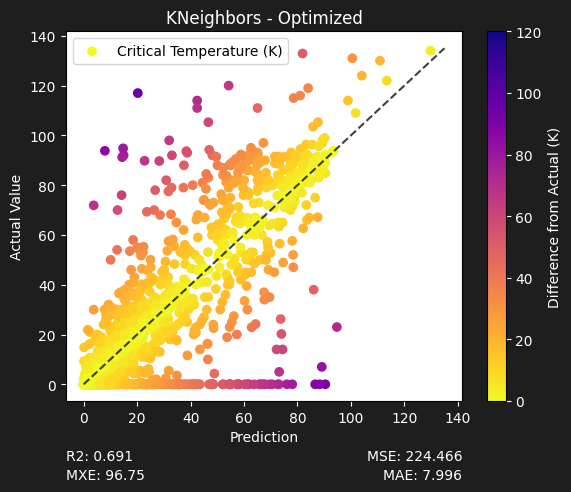

In [14]:
evaluate_one("KNeighbors - Optimized", KNeighborsRegressor, {'metric':'manhattan', 'n_jobs':-1, 'n_neighbors':8})

## Extra Trees Regressor

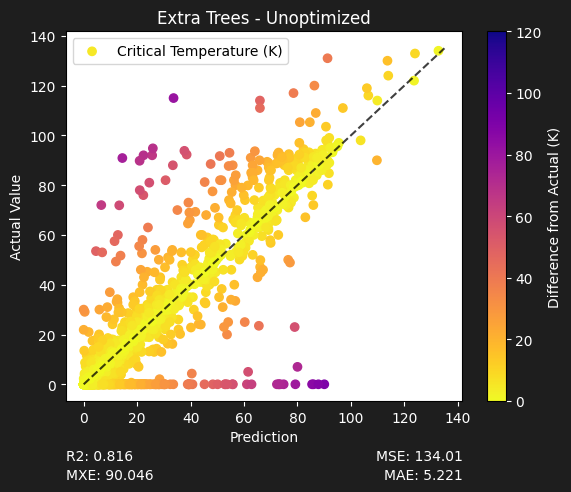

In [18]:
evaluate_one("Extra Trees - Unoptimized", ExtraTreesRegressor, {})

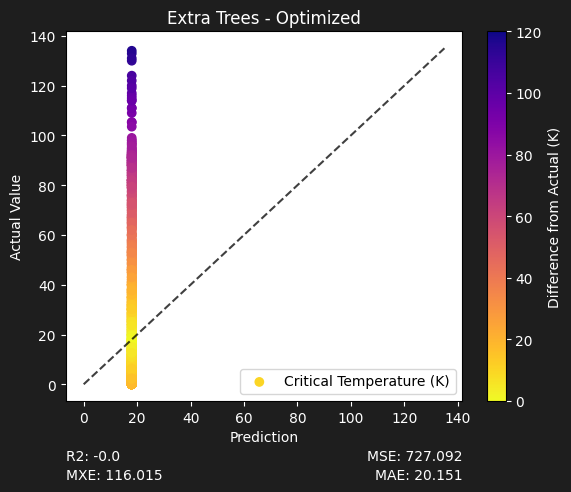

In [19]:
evaluate_one("Extra Trees - Optimized", ExtraTreesRegressor, {'min_samples_leaf':1.0, 'min_samples_split':0.1, 'n_estimators':250, 'n_jobs':-1})

## Stochastic Gradient Descent

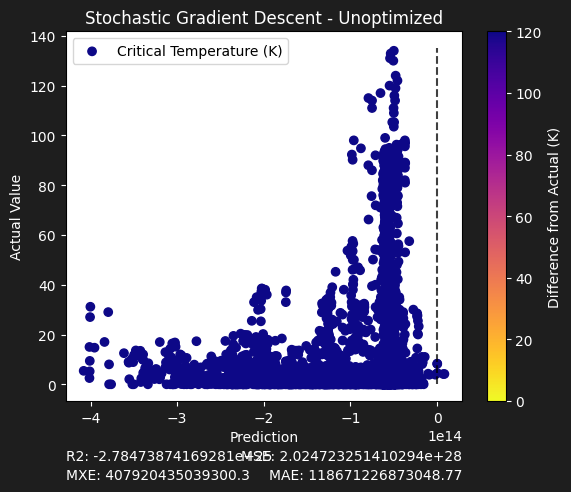

In [20]:
evaluate_one("Stochastic Gradient Descent - Unoptimized", SGDRegressor, {})

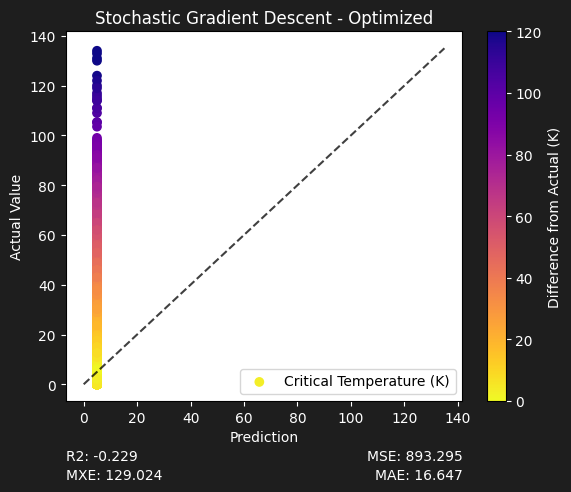

In [21]:
evaluate_one("Stochastic Gradient Descent - Optimized", SGDRegressor, {'alpha':1000.0, 'loss':'epsilon_insensitive', 'max_iter':1500, 'penalty':'l1'})

## Bayesian Regression

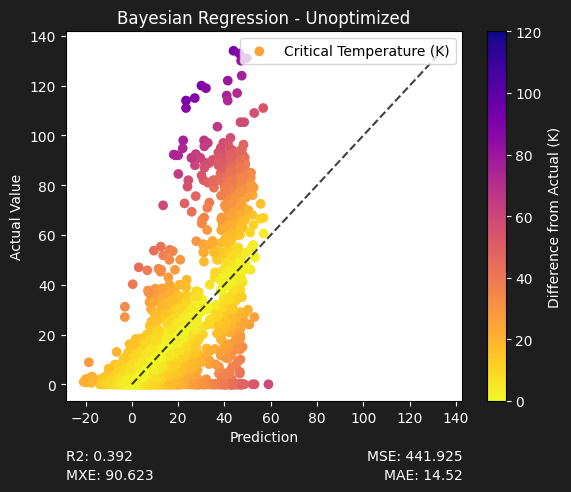

In [22]:
evaluate_one("Bayesian Regression - Unoptimized", BayesianRidge, {})

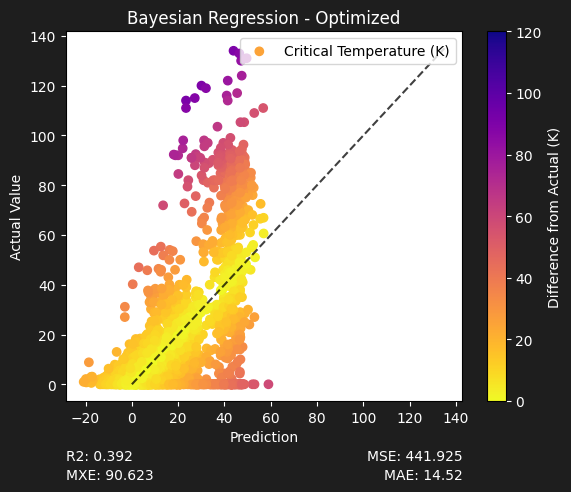

In [23]:
evaluate_one("Bayesian Regression - Optimized", BayesianRidge, {'alpha_init':1.2, 'lambda_init':0.0001})

## Superlearner

In [5]:
import_data(replace_inf=True)
# create a list of base-models
def get_models():
	models = list()
	models.append(SVR())
	models.append(ElasticNet(alpha=1e-05, l1_ratio=0.0))
	models.append(DecisionTreeRegressor())
	models.append(RandomForestRegressor())
	models.append(KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=8))
	# models.append(ExtraTreesRegressor())
	# models.append(SGDRegressor(alpha=1000.0, loss='epsilon_insensitive', max_iter=1500, penalty='l1'))
	# models.append(BayesianRidge(alpha_init=1.2, lambda_init=0.0001))

	return models

In [6]:
def get_super_learner(X):
	ensemble = SuperLearner(scorer=r2_score, folds=10, shuffle=True, sample_size=len(X))
	# add base models
	models = get_models()
	ensemble.add(models)
	# add the meta model
	ensemble.add_meta(LinearRegression())

	return ensemble
ensemble = get_super_learner(train_data)

In [7]:
evaluate_one("Superlearner", get_super_learner, {'X': train_data})

In [27]:
# dill.dump_session('../data/supercon_ml_latest_run.db') #this can dump a python session so I can resume later, after restarts and such